In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import pandas as pd

import nibabel as nib
import matplotlib.pylab as plt
import os

In [ ]:
training_data = pd.read_csv("C:\Users\marth\Documents\RSNAchallenge\train")
pos_data = pd.read_csv("C:\Users\marth\Documents\RSNAchallenge\train_localizers")

(512, 512, 228)
The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


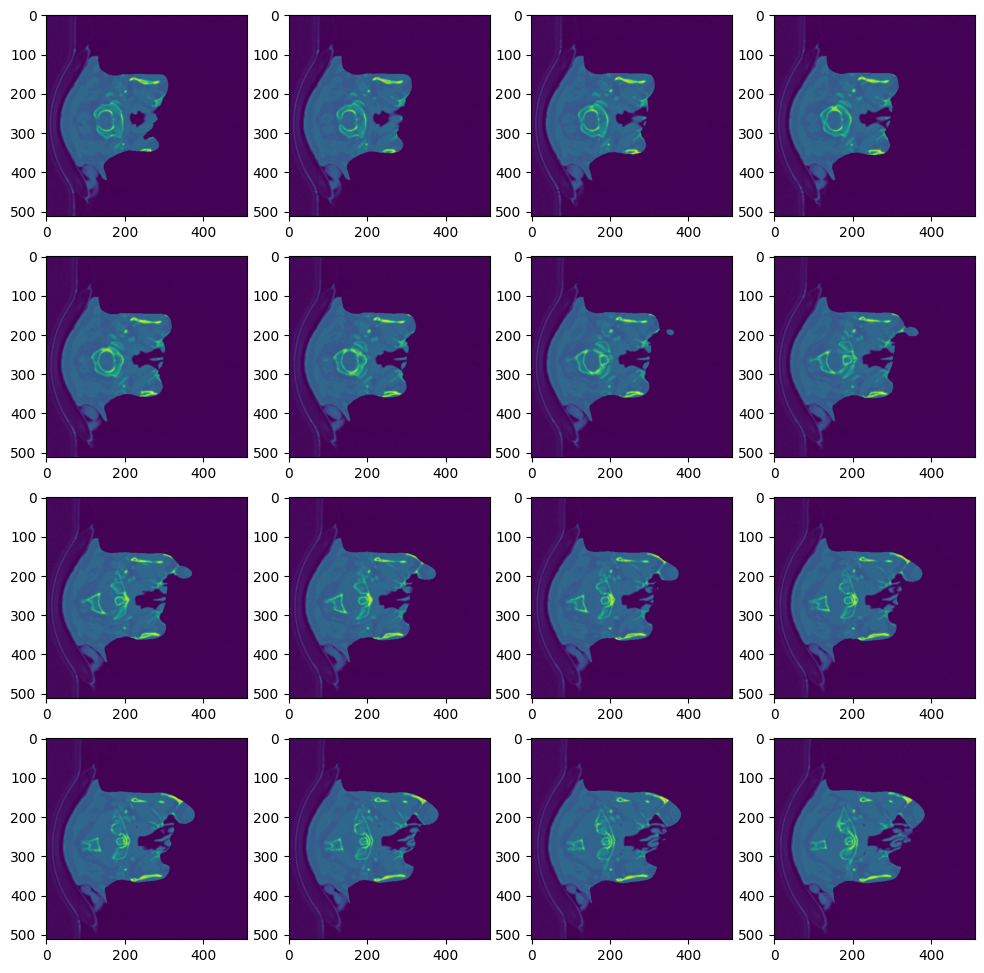

In [ ]:

img_dir = = r'C:\Users\marth\Documents\RSNAchallenge\segmentations\'
path = r'C:\Users\marth\Documents\RSNAchallenge\segmentations\1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii'

img = nib.load(path).get_fdata()

print(img.shape)


print(f"The .nii files are stored in memory as numpy's: {type(img)}.")



plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i])
plt.show()



In [ ]:
class brainScans(Dataset):

    def __init__ (self, data, img_dir, transform  =None):

        self.images = [os.listdir(img_dir)]
        
        self.data = data
        self.transform = transform

    def __len__(self):

        return len(self.images)

    def __getItem__(self, idx):
        
        return self.images(idx)
    












In [ ]:

dataset = brainScans(
    data = ,
    img_dir=img_dir,
    transform=transform
)

train_set, val_set = torch.utils.data.random_split(dataset, [416, 116] )
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)

In [16]:
class cnn3D(nn.module):

    def __init__(self):
        self.conv1 = nn.Conv3d(228, 128, 3, 2)
        self.pool = nn.MaxPool3d(3)
        

    def forward(self, x):








_IncompleteInputError: incomplete input (580931611.py, line 14)